<a href="https://colab.research.google.com/github/kiranraou/PYTHON_X/blob/main/Sequence_Learning_Assignment_2_NLP_NER_GMB_Corpus(Bi_LSTM_CRF_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sequence Learning - Assignment 2.**


**Named Entity Recognition (NER) on Groningen Meaning Bank (GMB) Corpus.**

**Problem Statement 2**

In Natural Language Processing (NLP), Entity Recognition is one of 
the common problems. NER is a method of extracting the relevant 
information from a large corpus and classifying those entities into 
predefined categories such as location, organization, name, and so 
on. 
In this problem you are given tagged data for entities, you have to 
predict those entities using LSTM model.



**Dataset Description:**

Dataset: CRF_POS_dataset.csv

This dataset is extracted from GMB(Groningen Meaning Bank) corpus, which is tagged, 
annotated, and built specifically to train the classifier to predict named entities such as name, 
location, etc. 
Essential info about entities:

-geo = Geographical Entity

-org = Organization

-per = Person

-gpe = Geopolitical Entity

-tim = Time indicator

-art = Artifact

-eve = Event

-nat = Natural Phenomenon

Above class of entities are labeled using the BIO scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The words which are not of interest are labeled with 0.



In [1]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


**Mounting Google Drive.**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries.**

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
import os

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

from prettytable import PrettyTable

### **Exploratory Data Analysis**

**Reading Dataset.**

In [7]:
#Read data
data = pd.read_csv('/content/drive/MyDrive/NIT Warangal _Industry Project/ner_dataset.csv', encoding="latin1").fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
data.shape


(1048575, 4)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


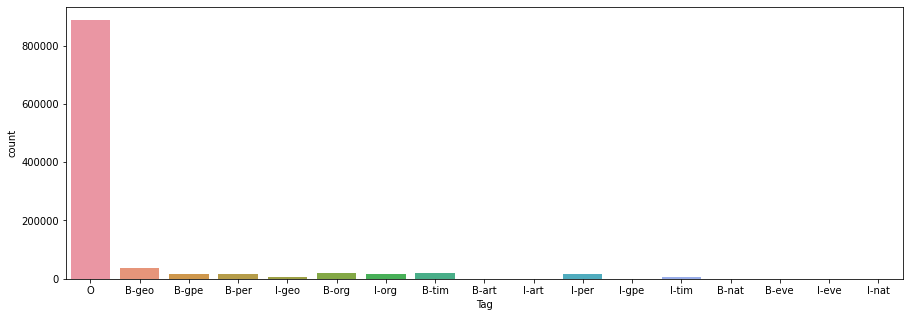

In [10]:
#Countplot
plt.figure(figsize=(15,5))
sns.countplot(x="Tag", data=data)
plt.show()

In [11]:
# Count of words with corresponding tag
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [12]:
data.isnull().sum(axis = 0)

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [13]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print("Number of unique words in dataset:", n_words)

Number of unique words in dataset: 35179


In [14]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 17


In [15]:
#To get a sentence
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [16]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [17]:
print("Number of sentences in dataset:", len(sentences))
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Number of sentences in dataset: 47959
Maximum sentence length: 104


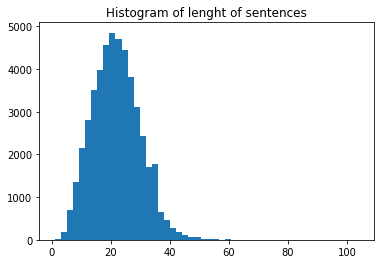

In [18]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title("Histogram of lenght of sentences")
plt.show()

In [19]:
#Words with B-org tag
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

In [20]:
#Words with I-org tag
data.loc[data['Tag'] == 'I-org', 'Word'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: Word, dtype: object

**Data Pre-processing.**

In [21]:
# Assigning index to all unique words and tags
max_len = 100
word_to_idx = {w: i + 1 for i, w in enumerate(words)}
tag_to_idx = {t: i for i, t in enumerate(tags)}

In [22]:
# Convert the sentence with words to sentence with corresponding index to each word
X = [[word_to_idx[w[0]] for w in s] for s in sentences]
# Padding sentences to make the length of all sentences same
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [23]:
# Converting tags to indices
y = [[tag_to_idx[w[2]] for w in s] for s in sentences]
# Padding tags to match length of sentence
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag_to_idx["O"])
# Make y categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [24]:
# Splitting data into train data (80%) and test data (20%)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

**Training the Model.**

In [25]:
# Defining model architecture

tf.compat.v1.set_random_seed(32)

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(n_tags, learn_mode = 'join', test_mode = 'viterbi') 
out = crf(model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [26]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_viterbi_accuracy])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 20)           703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 17)           1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Train the model
history = model.fit(X_tr, np.array(y_tr), batch_size=64, epochs=6, validation_split=0.2, verbose=1)


Train on 30693 samples, validate on 7674 samples
Epoch 1/6
30693/30693 [==============================] - 121s 4ms/step - loss: 0.1313 - crf_viterbi_accuracy: 0.9671 - val_loss: 0.0545 - val_crf_viterbi_accuracy: 0.9818
Epoch 2/6
30693/30693 [==============================] - 118s 4ms/step - loss: 0.0316 - crf_viterbi_accuracy: 0.9874 - val_loss: 0.0203 - val_crf_viterbi_accuracy: 0.9897
Epoch 3/6
30693/30693 [==============================] - 120s 4ms/step - loss: 0.0110 - crf_viterbi_accuracy: 0.9914 - val_loss: 0.0082 - val_crf_viterbi_accuracy: 0.9911
Epoch 4/6
30693/30693 [==============================] - 118s 4ms/step - loss: 4.2851e-04 - crf_viterbi_accuracy: 0.9929 - val_loss: 5.8587e-05 - val_crf_viterbi_accuracy: 0.9919
Epoch 5/6
30693/30693 [==============================] - 119s 4ms/step - loss: -0.0072 - crf_viterbi_accuracy: 0.9936 - val_loss: -0.0061 - val_crf_viterbi_accuracy: 0.9921
Epoch 6/6
30693/30693 [==============================] - 116s 4ms/step - loss: -0.013

In [28]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.054477,0.981805,0.131317,0.967066
1,0.020312,0.989662,0.031607,0.987361
2,0.008164,0.991143,0.011048,0.991381
3,0.000059,0.991920,0.000429,0.992897
4,-0.006094,0.992134,-0.007233,0.993607
5,-0.011914,0.992303,-0.013683,0.994107


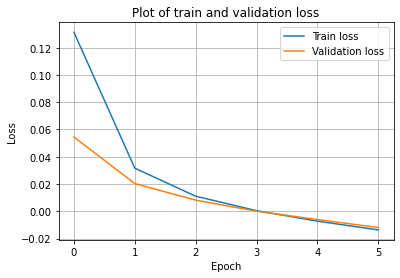

In [29]:
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Plot of train and validation loss")
plt.grid()
plt.show()

### **Evaluate the Model.**

In [30]:
# Predict output for test data
test_pred = model.predict(X_te, verbose=1)
# Index as key and tag as value
idx_to_tag = {i: w for w, i in tag_to_idx.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx_to_tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("Accuracy: ", accuracy_score(test_labels, pred_labels))


9592/9592 [==============================] - 14s 1ms/step
Accuracy:  0.9923853211009175


**Results.**

In [31]:
# Output for random test input
i = 1500
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
    
x = PrettyTable()
x.field_names = ["Word", "Actual Tag", "Predicted Tag"]

for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        x.add_row([words[w-1], tags[t], tags[pred]])
        
print(x)

+-----------+------------+---------------+
|    Word   | Actual Tag | Predicted Tag |
+-----------+------------+---------------+
|     In    |     O      |       O       |
|  Baghdad  |   B-geo    |     B-geo     |
|     ,     |     O      |       O       |
|    the    |     O      |       O       |
|  military |     O      |       O       |
|    said   |     O      |       O       |
|     a     |     O      |       O       |
|  roadside |     O      |       O       |
|    bomb   |     O      |       O       |
|  wounded  |     O      |       O       |
|   three   |     O      |       O       |
|   Iraqi   |   B-gpe    |     B-gpe     |
| civilians |     O      |       O       |
|     .     |     O      |       O       |
+-----------+------------+---------------+


In [32]:
# Query sentence other than test input
test_sentence = ["India", "is", "second", "most", "populous", "country"]

In [33]:
x_test_sent = pad_sequences(sequences=[[word_to_idx.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

In [34]:
# Output tags for query input
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)

x = PrettyTable()
x.field_names = ["Word", "Predicted Tag"]

for w, pred in zip(test_sentence, p[0]):
    x.add_row([w, tags[pred]])
        
print(x)

+----------+---------------+
|   Word   | Predicted Tag |
+----------+---------------+
|  India   |     B-geo     |
|    is    |       O       |
|  second  |       O       |
|   most   |       O       |
| populous |       O       |
| country  |       O       |
+----------+---------------+


**Conclusion.**

Bi-LSTM-CRF model is used for NER task

Model is evaluated on test data.

The accuracy of model after evaluation is 99.2% and result is really good.